In [14]:
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers
from sklearn.preprocessing import MinMaxScaler


In [3]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 



In [5]:
df = pd.read_csv('ddb_output.csv')
df.rename(columns={'humidity.S': 'humidity',
                   'temperature.S':'temperature',
                   'timestamp.S':'timestamp'},inplace=True)
df.drop(columns=['Unnamed: 0'],inplace=True)
#df.reset_index(drop=True,inplace=True)
df.sort_values(by='timestamp',inplace=True)
df

,humidity,temperature,timestamp
0,54.00,18.04,2023-04-21 12:36:04.168213
1,54.00,18.13,2023-04-21 12:36:07.120651
2,54.00,18.01,2023-04-21 12:36:10.007948
3,54.00,18.09,2023-04-21 12:36:12.959915
4,52.00,18.08,2023-04-21 15:48:08.632782
...,...,...,...
3041,56.35,21.63,2023-05-10 20:30:04.178828
3042,56.91,21.57,2023-05-10 20:40:04.682990
3043,56.72,21.54,2023-05-10 20:50:04.106947
3044,56.77,21.50,2023-05-10 21:00:04.586745


## Building a forecasting model 

In [7]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')
df_temp.head()

,temperature,timestamp
0,17.83,2023-04-28 08:25:00
1,17.85,2023-04-28 08:25:00
2,17.85,2023-04-28 08:30:00
3,17.88,2023-04-28 08:30:00
4,17.88,2023-04-28 09:20:00


### Baseline - persistence forecast 1,2,4 hours in advance

In [8]:
# Test - to predict temperature 1,2,4 hours in advance

def persistence_n_hours(n):

    timestamps_n_hr = df_temp['timestamp'].apply(lambda x: pd.Timestamp(x) + pd.Timedelta(hours=n))

    df_temp_n_hr_baseline = pd.DataFrame(list(zip(timestamps_n_hr,df_temp['temperature'])))
    df_temp_n_hr_baseline.rename(columns={0:'timestamp', 1:'value'},inplace=True)
    df_temp_n_hr_baseline['type'] = f'persist. {n}hrs'
    df_temp_n_hr_baseline = df_temp_n_hr_baseline[['value', 'timestamp', 'type']]
    df_temp_n_hr_baseline

    return df_temp_n_hr_baseline

persist_1_hr = persistence_n_hours(1)
persist_2_hr = persistence_n_hours(2)
persist_4_hr = persistence_n_hours(4)


In [12]:
df_temp['type'] = 'observation'
df_temp.rename(columns={'temperature':'value'},inplace=True)
df_temp

,value,type
timestamp,,
2023-04-28 08:25:00,17.83,observation
2023-04-28 08:25:00,17.85,observation
2023-04-28 08:30:00,17.85,observation
2023-04-28 08:30:00,17.88,observation
2023-04-28 09:20:00,17.88,observation
...,...,...
2023-05-10 20:30:00,21.63,observation
2023-05-10 20:40:00,21.57,observation
2023-05-10 20:50:00,21.54,observation


In [17]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])
df_temp.reset_index(inplace=True,drop=True)

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp['timestamp'] = df_temp['timestamp'].dt.round('5min')

df_temp['timestamp'] = df_temp['timestamp'].apply(lambda x: pd.to_datetime(x)) 

df_temp.set_index('timestamp',inplace=True)
df_temp

,temperature
timestamp,
2023-04-28 08:25:00,17.83
2023-04-28 08:25:00,17.85
2023-04-28 08:30:00,17.85
2023-04-28 08:30:00,17.88
2023-04-28 09:20:00,17.88
...,...
2023-05-10 20:30:00,21.63
2023-05-10 20:40:00,21.57
2023-05-10 20:50:00,21.54


In [13]:
df_temp.dropna(inplace=True)

# Some quick code to set this up: https://github.com/nachi-hebbar/Time-Series-Forecasting-LSTM

In [18]:
# Split the data, 50% in training and 25% in validation, 25% in test, and not randomly selected since this is a time series

scaler = MinMaxScaler()

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.5))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.75))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_validation = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)


In [19]:
sequence_length = 36 # takes in 36 readings, one every ten mins, uhh most of the time the data is this, so this is 6 hours
delay = sequence_length + 12 - 1 # The target is the temperature in an hour

train = TimeseriesGenerator(scaled_train[:-delay], scaled_train[delay:], 
                            length=sequence_length, batch_size=1, shuffle=True)

validation = TimeseriesGenerator(scaled_validation[:-delay], scaled_validation[delay:], 
                                 length=sequence_length, batch_size=1, shuffle=True)

test = TimeseriesGenerator(scaled_test[:-delay], scaled_test[delay:], 
                           length=sequence_length, batch_size=1, shuffle=True)


In [23]:
dropout = 0.3


inputs = keras.Input(shape=(36, 1))

x = layers.LSTM(16, dropout=dropout)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=10,
                    validation_data=validation)


test_mae = model.evaluate(test)[1]
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

print(f'Completed run for dropout = {dropout}. Test MAE = {test_mae}.' )
# return {'test_mae': test_mae, 'loss': loss, 'val_loss' : val_loss, 'epochs' : epochs}



Epoch 1/10


2023-05-15 09:16:28.925124: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


953/963 [============================>.] - ETA: 0s - loss: 0.0221 - mae: 0.1168

2023-05-15 09:16:33.648167: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


963/963 [==============================] - 5s 4ms/step - loss: 0.0221 - mae: 0.1167 - val_loss: 0.0319 - val_mae: 0.1489
Epoch 2/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0148 - mae: 0.1003 - val_loss: 0.0227 - val_mae: 0.1179
Epoch 3/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0154 - mae: 0.1028 - val_loss: 0.0229 - val_mae: 0.1220
Epoch 4/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0142 - mae: 0.0971 - val_loss: 0.0200 - val_mae: 0.1060
Epoch 5/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0137 - mae: 0.0955 - val_loss: 0.0258 - val_mae: 0.1305
Epoch 6/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0130 - mae: 0.0909 - val_loss: 0.0195 - val_mae: 0.1038
Epoch 7/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0130 - mae: 0.0923 - val_loss: 0.0248 - val_mae: 0.1271
Epoch 8/10
963/963 [==============================] - 4s 4ms/step - loss: 0.0134 - mae:

2023-05-15 09:17:10.443754: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


440/440 [==============================] - 0s 996us/step - loss: 0.0498 - mae: 0.1830
Completed run for dropout = 0.3. Test MAE = 0.18300741910934448.


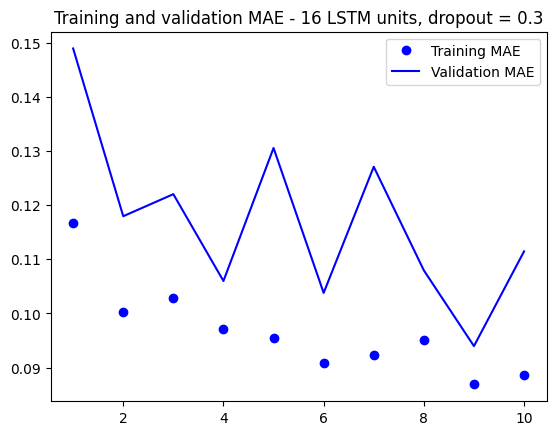

In [24]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title(f'Training and validation MAE - 16 LSTM units, dropout = {dropout}')
plt.legend()
plt.show()

In [ ]:
# Keras - time series forecasting example 

# https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [30]:
#learning_rate = 0.001

inputs = keras.Input(shape=(36, 1))

x = layers.LSTM(32, dropout=dropout)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(train,
                    epochs=10,
                    validation_data=validation,
                    callbacks=[es_callback, modelckpt_callback])


test_mae = model.evaluate(test)[1]
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 36, 1)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                4352      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2023-05-15 09:35:55.116467: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


951/963 [============================>.] - ETA: 0s - loss: 0.0251 - mae: 0.1174

2023-05-15 09:36:00.105217: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.02862, saving model to model_checkpoint.h5
963/963 [==============================] - 6s 5ms/step - loss: 0.0249 - mae: 0.1172 - val_loss: 0.0286 - val_mae: 0.1393
Epoch 2/10
954/963 [============================>.] - ETA: 0s - loss: 0.0152 - mae: 0.1023
Epoch 2: val_loss improved from 0.02862 to 0.02538, saving model to model_checkpoint.h5
963/963 [==============================] - 4s 4ms/step - loss: 0.0151 - mae: 0.1020 - val_loss: 0.0254 - val_mae: 0.1320
Epoch 3/10
959/963 [============================>.] - ETA: 0s - loss: 0.0150 - mae: 0.1011
Epoch 3: val_loss improved from 0.02538 to 0.02102, saving model to model_checkpoint.h5
963/963 [==============================] - 4s 4ms/step - loss: 0.0151 - mae: 0.1013 - val_loss: 0.0210 - val_mae: 0.1070
Epoch 4/10
961/963 [============================>.] - ETA: 0s - loss: 0.0143 - mae: 0.0986
Epoch 4: val_loss did not improve from 0.02102
963/963 [==============================] - 4s 4ms/step -

2023-05-15 09:36:37.643692: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


440/440 [==============================] - 0s 958us/step - loss: 0.0661 - mae: 0.2276


In [27]:
test_mae = model.evaluate(test)[1]
print(test_mae)

161/440 [=========>....................] - ETA: 0s - loss: 0.0492 - mae: 0.1852

2023-05-15 09:28:39.142882: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


440/440 [==============================] - 0s 947us/step - loss: 0.0514 - mae: 0.1930
0.19302210211753845
